# Parameter inference with the rtdist emulator
### Author: Ben Ricketts (b.ricketts@sron.nl)

This notebook is designed to take a simulated observation and perform various manners of parameter inference using the newly developed rtdist emulator. Extensive investigations of parameter space has been sparse up to this point due to computational restrictions but the drastic speed increase introduced by the emulator makes this feasible on the order of minutes to hours.

This also serves as a nice demonstration of why we developed the emulator in the first place: we wanted to be able to explore the limits of these models and serve as an example for further development of x-ray astronomy modelling. Even if modelling becomes computationally expensive, we can still perform extensive inference on actual data and retrieve more accurate representations of the physics in the sources that we observe.

In [1]:
import os
import time
from joblib import load
import copy

import numpy as np
import torch
from torch import nn
import pandas as pd
import emcee
from scipy.special import gammaln
import scipy
from scipy.stats import norm, poisson

#plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import corner
import matplotlib

#this is the only required import from rtdist-emulator - this serves as the baseline model
from network import RTFAST
#we also need to be able to model instruments in x-ray astronomy. This is courtesy of
#ndspec, developed by Matteo Lucchini at API. 
from ndspec import Response
#import the xillver table to approximate flux of the corona
#from reltrans._models import lmodxiller as xillver

## Response matrices

One of the key parts of actually being able to fit your observed data is translating what your instrument sees and what the original source outputs. We do this by convolving our model with an "instrument response". In traditional x-ray astronomy, we often use Xspec or SAS etc which will do this for us. Often they have an entire ecosystem behind them and they don't behave well when inputting data from outside their own ecosystem.

Because the emulator isn't built into these software directly, our emulator can't interface with the response matrix convolution built into these packages. Luckily for us, ndSpec has been partially developed with this restriction in mind, and we're able to perform response matrix convolutions with our emulator outputs.

The following cell imports response files from XMM-Newton as well as our simulated observation.

In [2]:
wrk_dir = os.getcwd()
resp = Response.ResponseMatrix(wrk_dir+"/ResponseFiles/PN.rmf")
resp.load_arf(wrk_dir+"/ResponseFiles/PN.arf")

Arf missing, please load it
No exposure header found in ARF, setting exposure time to 1 second
Arf loaded


We currently need to check that the exposure is correctly loaded from the response file. In the case of XMM-Newton, we have to manually set it. We take an observation exposure time for this demo that gives Poisson errors comparable to normal instrumental errors.

In [3]:
expo_time = 260000
resp.set_exposure_time(expo_time)

#resp = resp.ignore_channels(high_energy=0.1,low_energy=0)
resp.resp_matrix = resp.resp_matrix[resp.energ_lo>0.1]
resp.energ_hi = resp.energ_hi[resp.energ_lo>0.1]
resp.energ_lo = resp.energ_lo[resp.energ_lo>0.1]
resp.n_energs = len(resp.energ_lo)

## Observation
Let's also load a simulated observation from rtdist as well as specify the parameters used to generate the observation.

In [90]:
sim_obs = np.loadtxt("data/testing/observation_new.txt")
#xspec input parameters
xspec_pars = [6,0.9,57,-2,2e4,0.024917,2.5,1e6,1,17,50.,5e-2,1,3e7,0.02,0,0,0,0,0,0,-0.8,0.3,2.2e-4,1,1.]
#neural network input parameters
nn_pars = [6,0.9,57,2,2e4,0.024917,2.5,1e6,1,17,50,5e-2,1,3e7,0.02,0,0,-0.8,0.3,2.6e-4]
labels = ["Height","Spin","i",r"$r_{in}$",r"$r_{out}$","z",r"$\Gamma$","Distance",r"$A_{fe}$",
          "logNe","kTe",r"$N_H$","boost","Mass","h/r","b1","b2","phiAB","g","Anorm"]

In [91]:
hubble = nn_pars[5]*3e6/(nn_pars[7]*0.001) #currently incorrect by factor 10 - using to test inferred distances
print(hubble)

74.751


Let's also define our priors here. Here, we use log Uniform priors for some of our parameters

In [92]:
height_range      = [1.5,100]
spin_range        = [0,0.998]
inclination_range = [1,80]
r_inner_range     = [1,400]
r_outer_range     = [400,1e5]
z_range           = [0,0.1]
Gamma_range       = [1.4,3.4]
distance_range    = [3.5e5,5e7]
Afe_range         = [0.5,10]
logNe_range       = [15,20]
kte_range         = [5,500]
nH_range          = [1e-3,1]
boost_range       = [1e-2,10]
mass_range        = [1e4,1e11]
honr_range        = [0,0.176]
b1_range          = [0,2]
b2_range          = [-4,4]
phiAB_range       = [-3.14,3.14]
g_range           = [0,0.5]
anorm_range       = [1e-4,4]

range_all = [height_range,spin_range,inclination_range,r_inner_range,
             r_outer_range,z_range,Gamma_range,distance_range,Afe_range,
             logNe_range,kte_range,nH_range,boost_range,mass_range,
             honr_range,b1_range,b2_range,phiAB_range,g_range,anorm_range]

limits = np.asarray(range_all)

## Energy grids

Let's retrieve our energy grids.

In [93]:
#Let's also retrieve energy grids and bin widths for plotting purposes.
emid      = (resp.emin + resp.emax)/2
bin_width = resp.energ_hi-resp.energ_lo
egrid_lo  = resp.energ_lo
egrid_hi  = resp.energ_hi

## What do we see

While we're fitting a simulated observation from rtdist, we want to make sure that we're fitting what we'd observe from an actual telescope. Here we convolve our simulation with our response matrix and then perform a poisson realisation of it.

In [94]:
convolved = resp.convolve_response(sim_obs[:-1],"xspec")
pois_obs  = np.random.poisson(convolved)
data      = pois_obs

## Loading the emulator

To use RTFAST, we can simply call the RTFAST class from network.py and the class will automatically load everything necessary for you to use it.

In [95]:
model = RTFAST()

## Likelihood

In x-ray astronomy, we often use chi-squared fitting to fit data. This is generally because we bin our data such that we can approximate the distributions of energy bins as Gaussian distributions rather than Poisson distributions. This is usually fine as the amount of counts once integrated over a long observation has a Poisson distribution closely resembling a Gaussian distribution but isn't strictly correct, and becomes more of a concern when we perform Bayesian inference.

The following function defines the poisson likelihood given that k is the data count rate, and $\lambda$ is the model count rate.

$$
    - \log\mathcal{L} = \sum_{i=1}^{N} (\log k_i! - k_{i}\log\lambda_i +\lambda_i)
$$

We can substitute the $\log k_i!$ term for a gamma function which saves a lot of computation time while retaining the ability to compute the Bayesian evidence term (useful for direct model comparison).

In [96]:
def poisson_func(x,l):
    """
    Calculates the poisson likelihood.

    Parameters
    ----------
    x : numpy array
        a series of float data points that should be a counts from a spectra 
        generated by XSPEC or actual data.
    l : numpy array
        the model of the spectra to be compared to the original data.

    Returns
    -------
    summation : float
        likelihood probability that the proposed model is correct based on the
        data inputted (x).

    """
    #There are 3 terms in a log poisson likelihood: x*log(l) - l - sum{log(x!)} (gamma function = last term)
    poissons = x*torch.log(l) - l - gammaln(x + 1.0) #poisson likelihoods per data point
    summation = torch.sum(poissons) #sum poisson likelihoods for whole spectra
    if torch.isnan(summation): #if something goes wrong, e.g. there's an infinify somewhere, return invalid
        return -1e100
    return summation.detach().numpy()

def gaussian_func(x,l):
    """
    Calculates the gaussian likelihood.

    Parameters
    ----------
    x : numpy array
        a series of float data points that should be a counts from a spectra 
        generated by XSPEC or actual data.
    l : numpy array
        the model of the spectra to be compared to the original data.

    Returns
    -------
    summation : float
        likelihood probability that the proposed model is correct based on the
        data inputted (x).
    """
    gaussians = -1*((l - x)**2)/(2*(1.03*x)**2) #model emulator error as 3% scatter
    gaussians[x==0] = 0
    summation = torch.sum(gaussians)
    if torch.isnan(summation): #if something goes wrong, e.g. there's an infinify somewhere, return invalid
        return -1e100
    return summation.detach().numpy()

def poisson_gaussian_mixture(theta):
    """
    Combines the poissonian and gaussian likelihoods.

    Parameters:
    -----------
    theta: np.ndarray
        Set of parameters to calculate log likelihood of.
    
    Returns:
    --------
    log_likeli : float
        log likelihood of parameter set being the true model
    """
    x = torch.Tensor(data) #converts data to pytorch Tensor for gradient purposes
    l = torch.Tensor(convolve_sim(torch.Tensor(theta))) #evaluates model
    l[l==0] += 1e-20 #This offsets 0 counts by a slight amount (can't take the logarithm of 0)

    log_likeli = poisson_func(x,l) + gaussian_func(x,l)
    return log_likeli

def gaussian_scatter(theta, scatter=0.03):
    y_obs = data #converts data to pytorch Tensor for gradient purposes
    y_model = convolve_sim(torch.Tensor(theta)) #evaluates model
    y_model[y_model==0] += 1e-20 #This offsets 0 counts by a slight amount (can't take the logarithm of 0)
    
    # Calculate the total variance
    sigma_tot = np.sqrt((scatter * y_model) ** 2 + np.sqrt(y_obs) ** 2)
    
    # Calculate the log-likelihood
    log_likelihood = np.sum(norm.logpdf(y_obs, loc=y_model, scale=sigma_tot))
    
    if np.isnan(log_likelihood): #if something goes wrong, e.g. there's an infinify somewhere, return invalid
        return -1e100
        
    return log_likelihood

def priors(theta):
    """
    Imposes training priors as well as physically motivated priors.
    
    Parameters:
    -----------
    theta: np.ndarray
        Set of parameters to evaluate priors of.
    
    Returns:
    --------
    True:
        Parameter set is within priors
    False:
        Parameter set is outside of priors
    """
    #make sure all sampled parameters are within prior ranges
    for i,par in enumerate(theta):
        if par < limits[i,0] or par > limits[i,1]:
            print(f"Outside bounds. {labels[i]}: {par}")
            return False
    #following priors are training boundaries
    #check for highly comptonized thick disks with high iron abundances
    if (theta[6]>2.75)&(theta[8]>4)&(theta[9]>17):
        return False
    #unrealistic inferred hubble values
    hubble = theta[5]*3e6/(theta[7]*0.001) #currently incorrect by factor 10 - using to test inferred distances
    if hubble < 60 or hubble > 80:
        return False
    #coronal geometry invalid case
    height_min = 1+ np.sqrt(1-theta[1]**2)
    if 10**theta[0] < 1.5*height_min:
        return False
    """
    #uncomment this section to add accretion luminosity as a prior - you will need xillver installed for this
    #via Pyxspec or sherpa
    L = luminosity(theta)
    if L == False:
        return False
    """
    #to do: impose physical Anorm prior to restrict luminosities.
    return True

def log_likelihood(theta):
    """
    Calculates the log likelihood of a given set of parameters
    
    
    Parameters:
    -----------
    theta: np.ndarray
        Set of parameters to calculate log likelihood of.
    
    Returns:
    --------
    log_likeli : float
        log likelihood of parameter set being the true model
    """
    #checks for parameter set to be within priors - outside of priors returns large negative log likelihood
    if priors(theta) == False:
        log_likeli = -1e300
    else:
        log_likeli = gaussian_scatter(theta) #evaluate the likelihood of model based on data
    return log_likeli

def convolve_sim(theta):
    """
    Calls model and convolves with response matrix in pytorch compatible manner
    
    
    Parameters:
    -----------
    theta: np.ndarray
        Set of parameters to produce model of.
    
    Returns
    -------
    pred: torch.Tensor
        convolved model for poisson evaluation
    """
    pred = simulator(theta)
    pred = resp.convolve_response(pred.detach().numpy()[:-1],"xspec")
    return pred

def simulator(theta):
    """
    Calls emulator and rescales to actual data output
    
    Parameters:
    -----------
    theta: np.ndarray
        Set of parameters to calculate model of.
    
    Returns
    -------
    pred: torch.Tensor
        rtdist model result
    """
    theta = torch.Tensor(theta).double()
    pred = model(theta)
    return pred

## Checking the emulator

Let's make sure that the emulator is producing something that roughly agrees with the original model. This doesn't need to be exact, but it should be approximately correct

In [97]:
raw_sim = simulator(torch.Tensor(nn_pars).double()) #non-instrument convolved result
emulator = convolve_sim(torch.Tensor(nn_pars).double()) #fully convolved result

And let's plot a comparison of the original observation to the emulator's output.

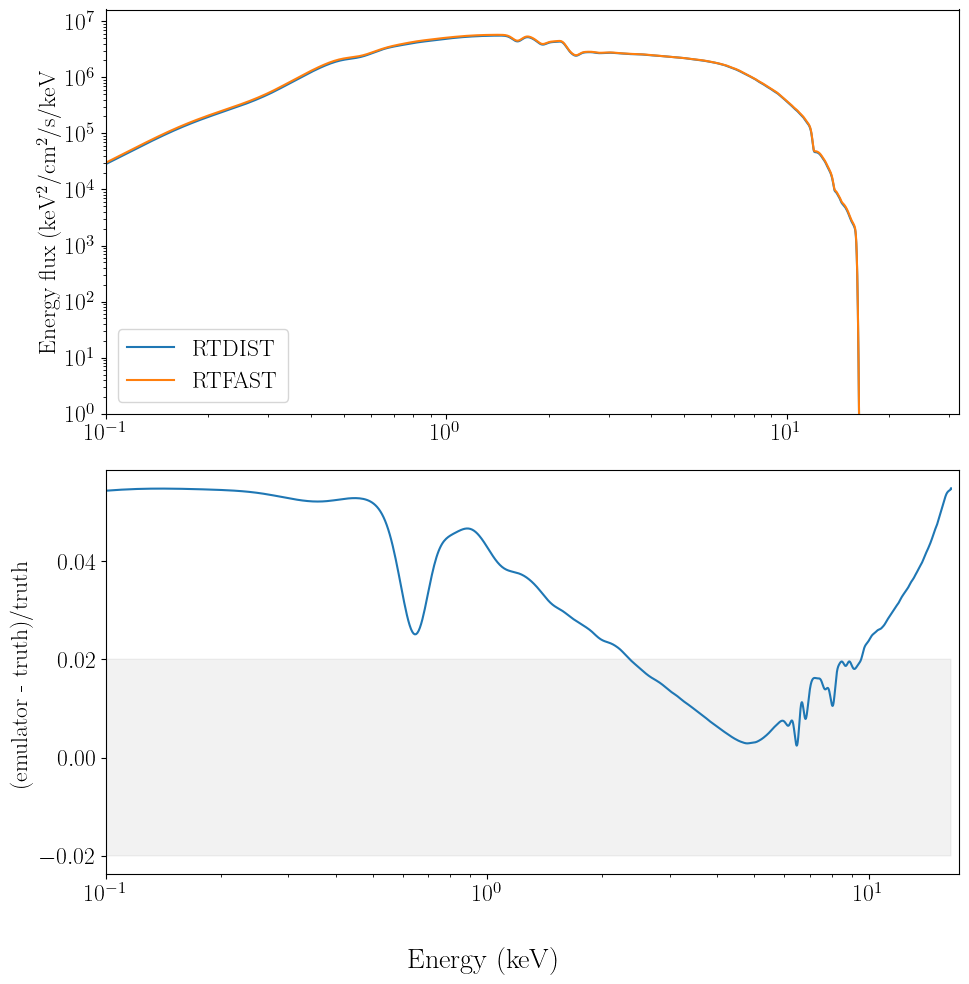

In [98]:
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].plot(emid,(emid**2)*convolved,label="RTDIST")
axs[0].plot(emid,(emid**2)*emulator,label = "RTFAST")
fig.supxlabel("Energy (keV)")
axs[0].set_ylabel("Energy flux (keV$^2$/cm$^2$/s/keV")
axs[0].legend()
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylim(1)
axs[0].set_xlim(0.1)
resids = np.abs((emulator[convolved!=0]-convolved[convolved!=0])/emulator[convolved!=0])
axs[1].fill_between(emid[convolved!=0],-0.02,0.02,color="grey",alpha=0.1)
axs[1].plot(emid[convolved!=0],resids)
#axs[1].axhline(0.03,ls="--")
axs[1].set_ylabel("(emulator - truth)/truth")
#axs[1].set_ylim(0.001)
#axs[1].set_yscale("log")
axs[1].set_xlim(0.1)
axs[1].set_xscale("log")
plt.tight_layout()
plt.savefig("samples/rtfast_compare.pdf")
plt.show()

Let's also compare to a poisson realisation of the simulated observation to get an impression of what this might look like on real data.

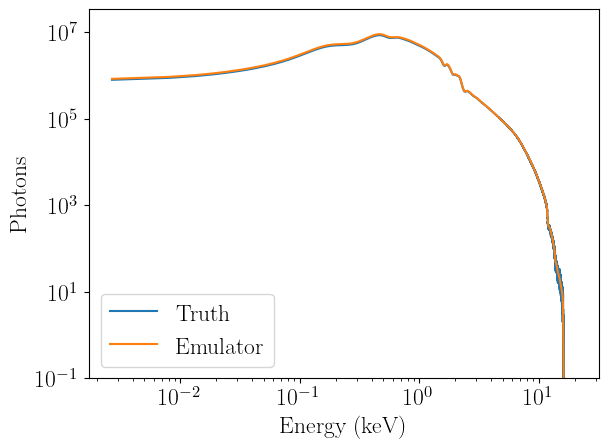

In [99]:
plt.plot(emid,pois_obs,label="Truth")
plt.plot(emid,emulator,label = "Emulator")
plt.xlabel("Energy (keV)")
plt.ylabel("Photons")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-1)
plt.tight_layout()
plt.show()

/var/folders/qn/p7z02jy121x20hh4s27zljym0000gp/T/ipykernel_82941/3483055767.py:1: RuntimeWarning: invalid value encountered in divide
  errs = (np.sqrt(pois_obs)/pois_obs)


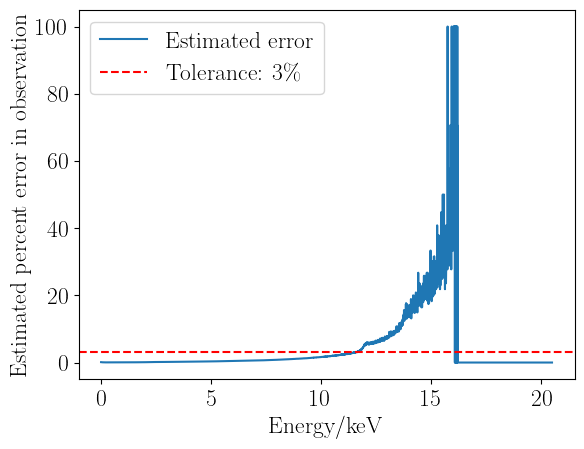

In [80]:
errs = (np.sqrt(pois_obs)/pois_obs)
errs[np.isnan(errs)] = 0
plt.plot(emid,errs*100,label="Estimated error")
plt.axhline(3,label="Tolerance: 3\%",ls="--",c="r")
plt.xlabel("Energy/keV")
plt.ylabel("Estimated percent error in observation")
plt.legend()
plt.show()

We see a good level of agreement here, albeit off by a few percent. This tends not to be a concern when performing fits on real data - the emulator stochastically sits either side of the "true" model and our posterior evaluation will be flatter because of this.

We can also test that the expected behaviour of changing one parameter occurs when using RTFAST. Let's adjust for a set of parameters with more obvious absorption and reflection lines and then vary a visually identifiable parameter, $\Gamma$.

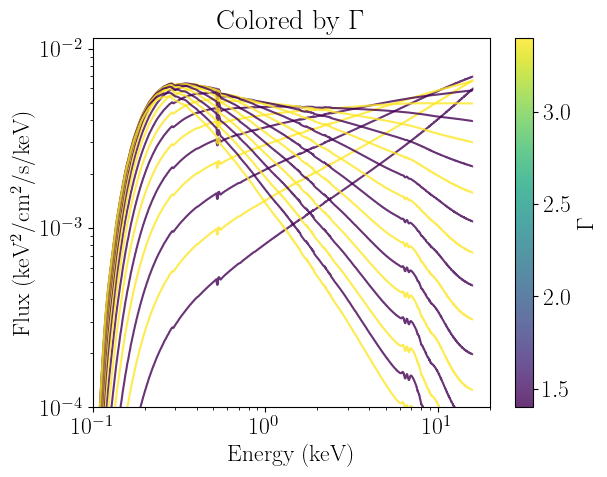

In [15]:
gma_range = np.linspace(1.4,3.4,20)
np_nn_pars = np.asarray(nn_pars)[np.newaxis,:]
nn_pars_range = np.repeat(np_nn_pars,20,axis=0)
nn_pars_range[:,0] = 3
nn_pars_range[:,6] = gma_range
nn_pars_range[:,7] = 3.5e5
nn_pars_range[:,9] = 15
nn_pars_range[:,11] = 1e-2
nn_pars_range[:,12] = 5
nn_pars_range[:,13] = 3e10
segs = [np.column_stack([egrid_lo, 
                         ((egrid_lo)**2)*simulator(torch.Tensor(par_set).double()).detach().numpy()[1:]/bin_width]) 
        for par_set in nn_pars_range]

fig, ax = plt.subplots()
lc = matplotlib.collections.LineCollection(segs, array = Gamma_range,
                                           alpha = 0.8)
ax.add_collection(lc)
axcb = fig.colorbar(lc)
axcb.set_label(r"$\Gamma$")
ax.set_title(r"Colored by $\Gamma$")
ax.set_ylabel(r"Flux (keV$^2$/cm$^2$/s/keV)")
ax.set_xlabel("Energy (keV)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-4)
ax.set_xlim(1e-1,20)
plt.show()
plt.close()

And finally let's take a look at Anorm.

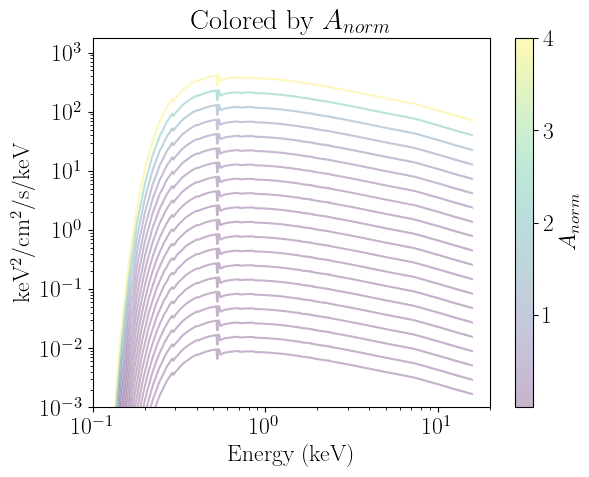

In [16]:
anorm_ranges = np.logspace(-4,np.log10(4),20)
np_nn_pars = np.asarray(nn_pars)[np.newaxis,:]
nn_pars_range = np.repeat(np_nn_pars,20,axis=0)
nn_pars_range[:,-1] = anorm_ranges
segs = [np.column_stack([egrid_lo, 
                         ((egrid_lo)**2)*simulator(torch.Tensor(par_set).double()).detach().numpy()[1:]/bin_width]) 
        for par_set in nn_pars_range]

fig, ax = plt.subplots()
lc = matplotlib.collections.LineCollection(segs, array = anorm_ranges,
                                           alpha = 0.3)
ax.add_collection(lc)
axcb = fig.colorbar(lc)
axcb.set_label(r"$A_{norm}$")
ax.set_title(r"Colored by $A_{norm}$")
ax.set_ylabel(r"keV$^2$/cm$^2$/s/keV")
ax.set_xlabel("Energy (keV)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-3)
ax.set_xlim(1e-1,20)
plt.show()
plt.close()

## Out of bounds - a cautionary tale

One thing to take into consideration is when you call RTFAST outside of its training bounds. Machine learning techniques do incredibly poorly outside of its training bounds and the authors strictly urge any users to _never_ use RTFAST outside of its specified training boundaries.

Just as an example, let's compare a pregenerated spectrum from RTDIST which is reasonable to generate and compare it to RTFAST's product.

/Users/benr/opt/miniconda3/envs/ciao-4.16/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


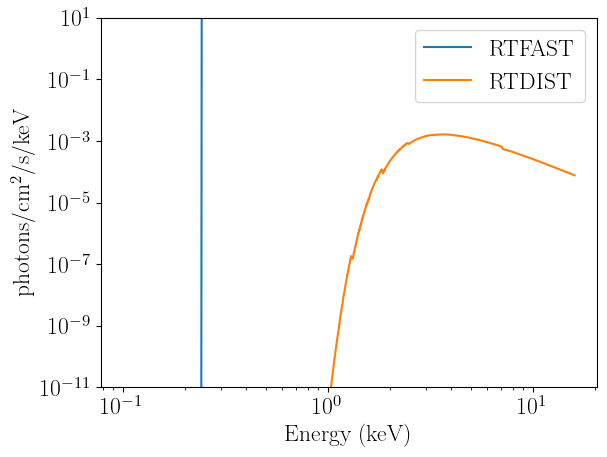

In [17]:
ooo_bounds_pars = nn_pars.copy()
ooo_bounds_pars[11] = 10
ooo_bounds_rtfast = simulator(torch.Tensor(ooo_bounds_pars).double()).detach().numpy()[1:]/bin_width
ooo_bounds_rtdist = np.loadtxt("data/testing/ooobounds.txt")[1:]/bin_width
plt.plot(egrid_lo,ooo_bounds_rtfast,label="RTFAST")
plt.plot(egrid_lo,ooo_bounds_rtdist,label="RTDIST")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel(r"photons/cm$^2$/s/keV")
plt.ylim(1e-11,10)
plt.legend()
plt.show()

We can see a clear discrepancy between the two in that RTFAST actually returns infinities in most energy bins! We should note that the edges of the training space may give you smaller discrepancies that may seem reasonable but should still be avoided for robustness' sake.

## Nested Sampling (dynesty)

We can also explore our parameter space with nested sampling. You can find out more about dynesty and how nested sampling works here: https://dynesty.readthedocs.io/en/stable/. What we care about is how it can help us map the posterior of our fairly complex and degenerate model.

Nested sampling boasts some nice gains, prinicipally being able to derive statistical uncertainties as well as being able to sample from complex multimodal distributions. It also tends to be quite fast in comparison to emcee as well as being able to retrieve the Bayesian evidence - key for model comparison.

In [18]:
import dynesty
from dynesty import plotting as dyplot

Dynesty requires its own form of transforming from uniform 0 to 1 draws to actual input parameters. The following function does this

In [19]:
def ptform(u):
    """
    Reduced priors to realistic ranges.
    """
    height_range = [1.5,10]
    spin_range = [0.1,0.998]
    inclination_range = [1,40]
    r_inner_range = [1,400]
    #r_outer_range = [400,1e5]
    #z_range = [0.01,0.03]
    Gamma_range = [2,3]
    distance_range = [np.log10(3.5e5),np.log10(5e7)]
    Afe_range = [1,3]
    logNe_range = [15,17]
    #kte_range = [5,200]
    nH_range = [np.log10(1e-2),np.log10(1)]
    #boost_range = [1e-2,5]
    #mass_range = [1e5,1e7]
    #honr_range = [0,0.1]
    #b1_range = [0,0.2]
    #b2_range = [-1,1]
    #phiAB_range = [-2,0]
    #g_range = [0,0.5]
    anorm_range = [np.log10(1e-4),np.log10(1e-2)]

    """
    range_all = [height_range,spin_range,inclination_range,
                 r_inner_range,Gamma_range,distance_range,
                 Afe_range,logNe_range,nH_range,
                 anorm_range]
    """
    range_all = [Gamma_range,nH_range,anorm_range]

    #powers = [5,8,9]
    powers = [1,2]
    
    for i,lims in enumerate(range_all):
        u[i] = u[i]*(lims[1]-lims[0]) + lims[0]
        if i in powers:
            u[i] = 10**u[i]
    return u
    
def ptform_vector(u):
    """
    Reduced priors to realistic ranges.
    """
    height_range = [1.5,10]
    spin_range = [0.1,0.998]
    inclination_range = [1,40]
    r_inner_range = [1,400]
    #r_outer_range = [400,1e5]
    #z_range = [0.01,0.03]
    Gamma_range = [2,3]
    distance_range = [np.log10(3.5e5),np.log10(5e7)]
    Afe_range = [1,3]
    logNe_range = [15,17]
    #kte_range = [5,200]
    nH_range = [np.log10(1e-3),np.log10(1)]
    #boost_range = [1e-2,5]
    #mass_range = [1e5,1e7]
    #honr_range = [0,0.1]
    #b1_range = [0,0.2]
    #b2_range = [-1,1]
    #phiAB_range = [-2,0]
    #g_range = [0,0.5]
    anorm_range = [np.log10(1e-4),np.log10(1e-2)]

    """
    range_all = [height_range,spin_range,inclination_range,
                 r_inner_range,Gamma_range,distance_range,
                 Afe_range,logNe_range,nH_range,
                 anorm_range]
    """
    range_all = [Gamma_range,nH_range,anorm_range]

    #powers = [5,8,9]
    powers = [1,2]
    
    for i,lims in enumerate(range_all):
        u[:,i] = u[:,i]*(lims[1]-lims[0]) + lims[0]
        if i in powers:
            u[:,i] = 10**u[:,i]
    return u
    
def insert_fixed_pars(theta):
    """
    If you are fixing certain parameters, insert them here.
    """
    theta = np.insert(theta,0,nn_pars[0]) #fixed height
    theta = np.insert(theta,1,nn_pars[1]) #fixed spin
    theta = np.insert(theta,2,nn_pars[2]) #fixed inclination
    theta = np.insert(theta,3,nn_pars[3]) #fixed inner radius
    theta = np.insert(theta,4,nn_pars[4]) #fixed outer radius
    theta = np.insert(theta,5,nn_pars[5]) #fixed z
    #theta = np.insert(theta,6,nn_pars[6]) #fixed gamma
    theta = np.insert(theta,7,nn_pars[7]) #fixed distance
    theta = np.insert(theta,8,nn_pars[8]) #fixed afe
    theta = np.insert(theta,9,nn_pars[9]) #fixed logNe
    theta = np.insert(theta,10,nn_pars[10]) #fixed kte
    #theta = np.insert(theta,11,nn_pars[11]) #fixed nh
    theta = np.insert(theta,12,nn_pars[12]) #fixed boost
    theta = np.insert(theta,13,nn_pars[13]) #fixed mass
    theta = np.insert(theta,14,nn_pars[14]) #fixed h/r
    theta = np.insert(theta,15,nn_pars[15]) #fixed b1
    theta = np.insert(theta,16,nn_pars[16]) #fixed b2
    theta = np.insert(theta,17,nn_pars[17]) #fixed phiAB
    theta = np.insert(theta,18,nn_pars[18]) #fixed g
    #theta = np.insert(theta,19,nn_pars[19]) #fixed anorm
    return theta

def log_likelihood_fixed(theta):
    """
    Calculates the log likelihood of a given set of parameters
    
    
    Parameters:
    -----------
    theta: np.ndarray
        Set of parameters to calculate log likelihood of.
    
    Returns:
    --------
    log_likeli : float
        log likelihood of parameter set being the true model
    """
    theta = insert_fixed_pars(theta)
    #checks for parameter set to be within priors - outside of priors returns large negative log likelihood
    if priors(theta) == False:
        log_likeli = -1e300
    else:
        log_likeli = gaussian_scatter(theta,scatter=0.05) #evaluate the poisson likelihood of model based on data
    return log_likeli

def convolve_sim_fixed(theta):
    """
    Convolves RTFAST's output with the response matrix
    """
    theta = insert_fixed_pars(theta)
    pred = simulator(theta)
    pred = resp.convolve_response(pred.detach().numpy()[:-1],"xspec")
    return pred

In [20]:
times = []
for i in range(100):
    start = time.time()
    log_likelihood(nn_pars)
    end = time.time()
    times.append(end-start)
print(np.mean(times))

0.012450799942016602


We can then define the nested sampling in only a few lines and run this. Increasing nlive (or live points) will increase computation time but more accurately map the posterior. As an estimate, 500 live points takes approximately 40 minutes to evaluate and 2000 live points takes approximately 1.5-2 hours to evaluate.

In [21]:
ndim=3
sampler = dynesty.NestedSampler(log_likelihood_fixed, ptform, ndim, nlive=500,bound="multi")
sampler.run_nested()
sresults = sampler.results

9750it [07:17, 22.27it/s, +500 | bound: 24 | nc: 1 | ncall: 36353 | eff(%): 28.589 | loglstar:   -inf < -158152.513 <    inf | logz: -158171.220 +/-  0.190 | dlogz:  0.001 >  0.509]


Let's retrieve the importance and samples for plotting of the posterior samples later

In [52]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = sresults.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = sresults.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(sresults)

Let's select a few parameters to actually plot

In [53]:
new_results = copy.deepcopy(sresults)
nn_pars_indices = [0,1,3,7,9,19]
nn_pars_indices_full = [6,11,19]
nn_pars_true = np.asarray(nn_pars)[nn_pars_indices_full]
labels_plots = np.delete(labels,[0,1,2,3,4,5,7,8,9,10,12,13,14,15,16,17,18])
print(labels_plots)
print(nn_pars_true)

['$\\Gamma$' '$N_H$' 'Anorm']
[2.5e+00 5.0e-02 2.2e-04]


We can plot the equivalent of MCMC chains.

/Users/benr/opt/miniconda3/envs/ciao-4.16/lib/python3.11/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


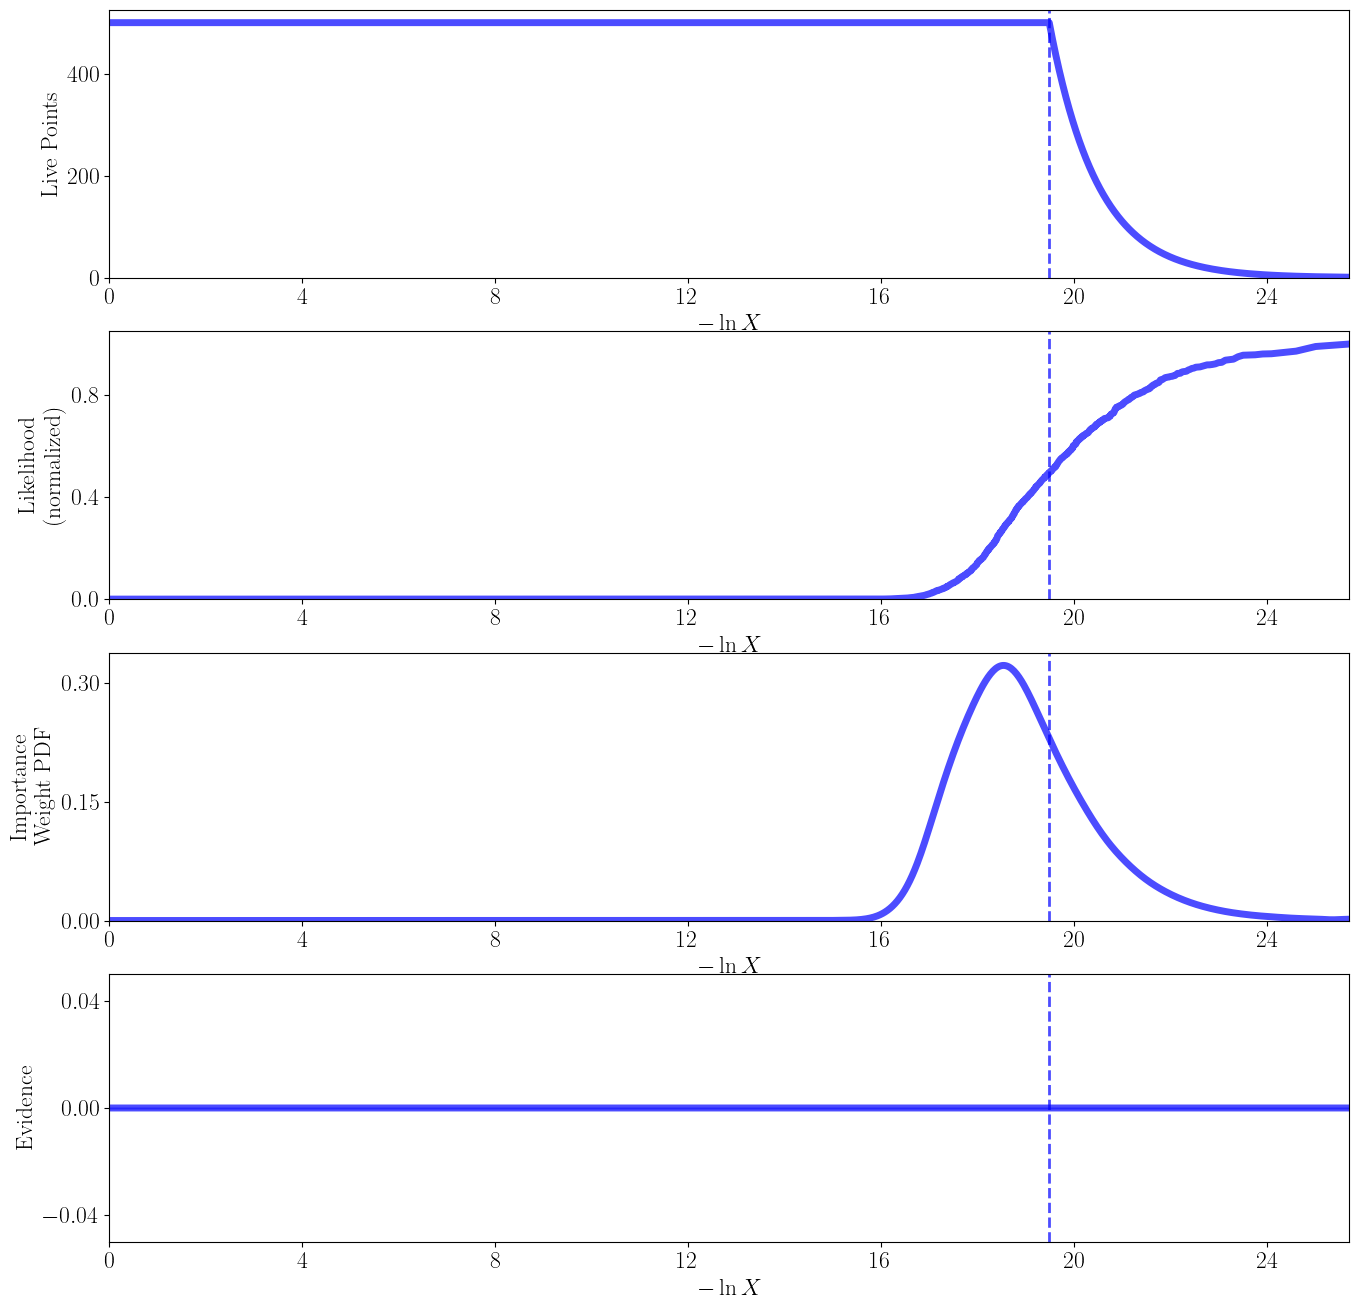

In [54]:
fig, axes = dyplot.runplot(sresults)
plt.show()

Dynesty has it's own plotting functions, but they tend to throw a lot more samples that tends to obscure the complexity of the posterior in the case of rtdist.

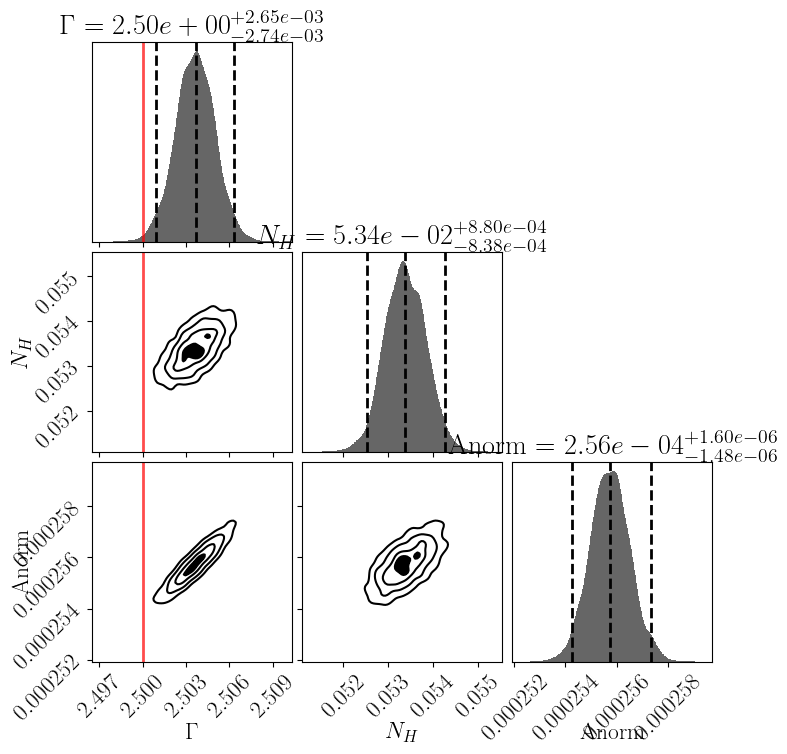

[2.5e+00 5.0e-02 2.2e-04]


In [55]:
cfig, caxes = dyplot.cornerplot(new_results,truths=nn_pars_true,labels=labels_plots,
                                show_titles=True,title_fmt = ".2e")
plt.show()
print(nn_pars_true)

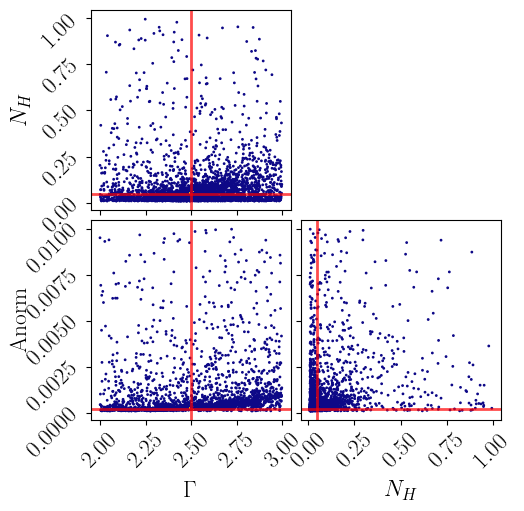

In [56]:
cfig, caxes = dyplot.cornerpoints(new_results,truths=nn_pars_true,labels=labels_plots)
plt.show()

We're able to evaluate the model based on samples from our posterior and create many realisations. We can then plot a mean model and see how that compares to our data.

In [57]:
log_likelihoods = sresults.logl
sorted_indices = np.argsort(log_likelihoods)[::-1]  # Sort in descending order
sorted_samples = samples_equal[sorted_indices]
sorted_log_likelihoods = log_likelihoods[sorted_indices]

# Select the top n samples
n_top_samples = 20000  # For example, select the top 100 samples
top_samples = sorted_samples[:n_top_samples]
top_log_likelihoods = sorted_log_likelihoods[:n_top_samples]

In [58]:
Gamma_range = [2,3]
nH_range = [np.log10(1e-2),np.log10(1)]
anorm_range = [np.log10(1e-4),np.log10(1e-2)]
ranges = np.array([Gamma_range,nH_range,anorm_range])
new_samples = samples_equal
new_samples[:,[1,2]] = np.log10(new_samples[:,[1,2]])

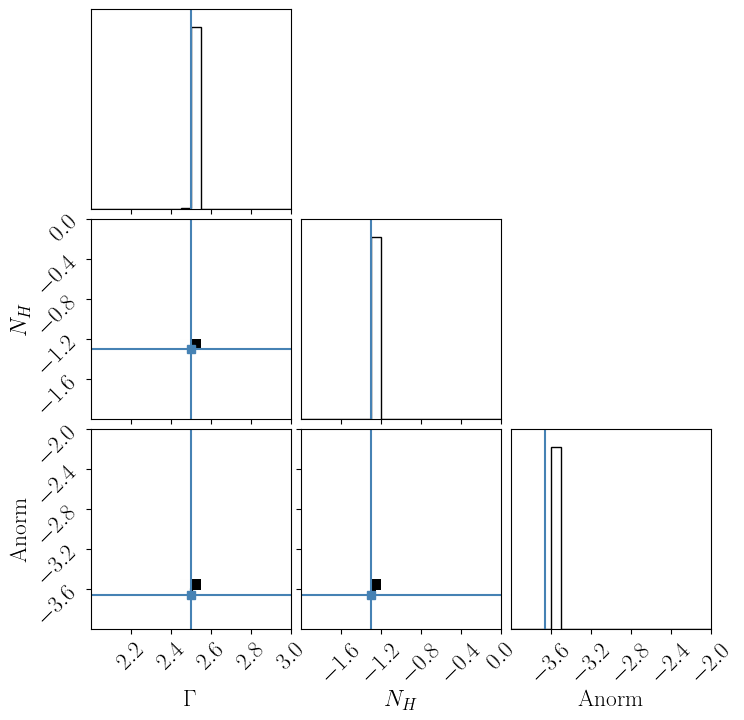

In [59]:
nn_pars_true_logged = nn_pars_true
nn_pars_true_logged[[1,2]] = np.log10(nn_pars_true_logged[[1,2]])
fig = corner.corner(
    new_samples,
    range=ranges,
    labels=labels_plots,  # Parameter names
    truths=nn_pars_true,  # True values (if known)
    title_fmt=".2f"  # Format of the titles
)

/var/folders/qn/p7z02jy121x20hh4s27zljym0000gp/T/ipykernel_82941/1219896983.py:26: RuntimeWarning: divide by zero encountered in divide
  axs[2].scatter(emid,(pois_obs-np.mean(model_draws,axis=0))/np.sqrt(pois_obs),s=1,marker="+")
/var/folders/qn/p7z02jy121x20hh4s27zljym0000gp/T/ipykernel_82941/1219896983.py:26: RuntimeWarning: invalid value encountered in divide
  axs[2].scatter(emid,(pois_obs-np.mean(model_draws,axis=0))/np.sqrt(pois_obs),s=1,marker="+")


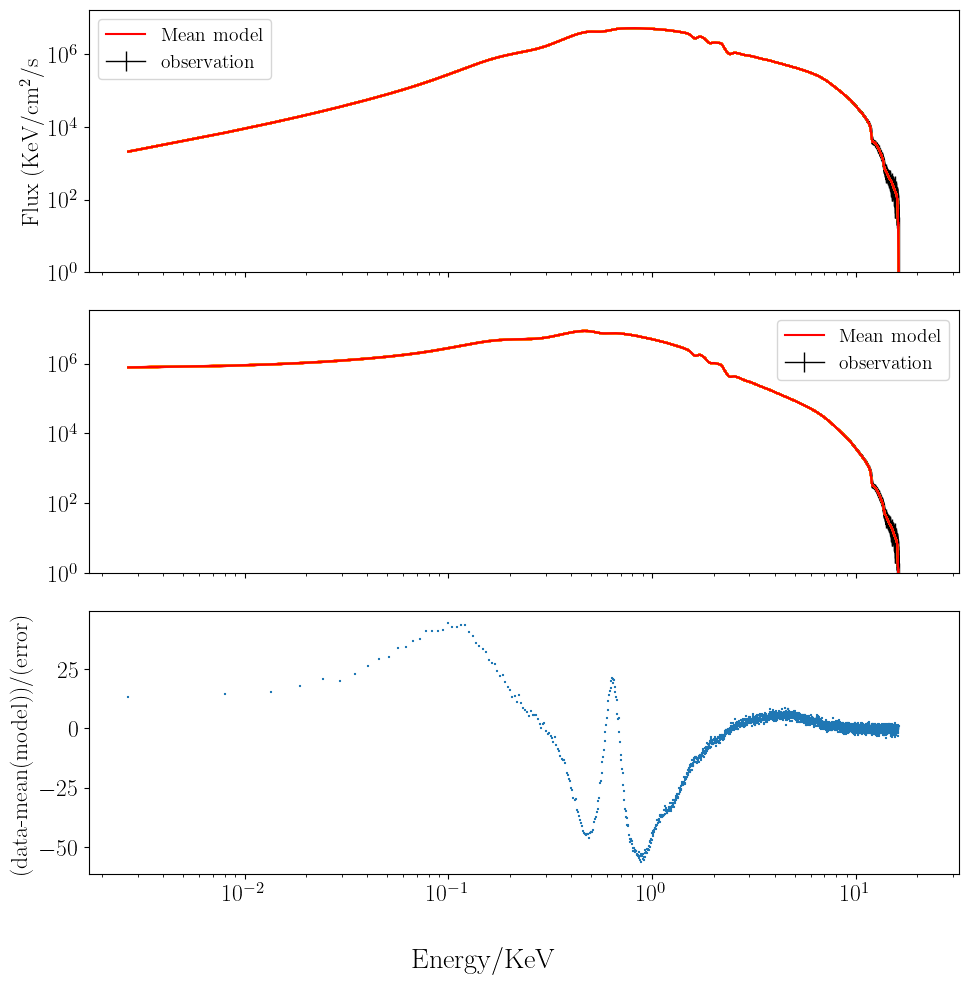

In [29]:
fig, axs = plt.subplots(3,sharex=True,figsize=(10,10))
inds = np.random.randint(0,top_samples.shape[0],size=500)
model_draws = []
for ind in inds:
    sample = top_samples[ind]
    model_eval = convolve_sim_fixed(sample)
    model_draws.append(model_eval)
    axs[0].plot(emid, emid*model_eval, "C1", alpha=0.1,zorder=2)
    axs[1].plot(emid, model_eval, "C1", alpha=0.1,zorder=2)
model_draws = np.asarray(model_draws)
axs[0].plot(emid,emid*np.mean(model_draws,axis=0),"r",label="Mean model",zorder=3)
axs[0].errorbar(emid, emid*pois_obs,yerr=emid*np.sqrt(pois_obs), label="observation",color="black",lw=1,zorder=1)
axs[1].plot(emid,np.mean(model_draws,axis=0),"r",label="Mean model",zorder=3)
axs[1].errorbar(emid,pois_obs,yerr=np.sqrt(pois_obs), label="observation",color="black",lw=1,zorder=1)

axs[0].legend(fontsize=14)
fig.supxlabel("Energy/KeV")
axs[0].set_ylabel(r"Flux (KeV/cm$^2$/s")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylim(1)
axs[1].legend(fontsize=14)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(1)
axs[2].scatter(emid,(pois_obs-np.mean(model_draws,axis=0))/np.sqrt(pois_obs),s=1,marker="+")
axs[2].set_ylabel("(data-mean(model))/(error)")
#axs[2].set_yscale("symlog")
plt.tight_layout()
plt.show()

This seems like a good fit and we recover the parameters to simulate our observation! The emulator looks to be in working order.

## Appendices

All that follows are extra functions that give context to decisions made earlier.

In [30]:
def Anorm_wrapper(pars):
    """
    This function recalculates the Anorm input parameter of rtdist from the 
    generated values of flux. This allows considerably more efficient sampling
    of Anorm - only physically plausible scenarios are considered and we 
    have physical reasoning behind the Anorm values chosen. The network is
    trained on integrated coronal fluxes ranging from 1e-8 to 1e-12 ergs.

    Parameters
    ----------
    pars : np.ndarray
        the curated hypercube of parameters that the emulator will eventually
        be trained on.

    Returns
    -------
    new_lhc : np.ndarray
        latin hypercube with "coronal flux" parameter replaced with Anorm.

    """
    #calculate g_0
    h = 10**pars[:,0]
    a = pars[:,1]
    Dh = h**2 -2*h +a**2
    g_so = np.sqrt(Dh/(h**2 + a**2))
    #calculate luminosity of corona
    F = 10**pars[:,19]              #Flux of corona in erg/cm^2/s
    gamma = pars[:,6]               #photon index
    Afe = pars[:,8]
    z = pars[:,5]
    refl_frac = np.zeros(gamma.shape)
    inc = pars[:,2]
    #calculate normalisation for each flux spectra
    integrals = np.zeros(gamma.shape)
    #cutoff in keV
    E_cut = np.ones(gamma.shape)*300
    logxi = np.ones(gamma.shape)
    xnorm = np.ones(gamma.shape)
    xill_pars = np.vstack((gamma,Afe,E_cut,logxi,z,inc,refl_frac,xnorm)).T
    #energies from 0.1keV to 1MeV
    bins = 1000
    egrid = np.logspace(-1,3,num = bins)
    e_mid = (egrid[1:] - egrid[:-1])/(np.log10(egrid[1:])-np.log10(egrid[:-1]))
    e_mid = e_mid * 1.60218e-9 #convert to erg
    
    def integrate(pars):
        continuum = _models.lmodxillver(pars, egrid)
        integral = np.trapz(continuum,egrid)*1.60218e-9
        return integral
    integrals = [integrate(pars) for pars in xill_pars]
    integrals = np.asarray(integrals)
    Anorm = F/(g_so**(gamma-2)*integrals)
    pars[:,19] = Anorm   #Replace flux generated with Anorm parameters
    return pars

In [31]:

def luminosity(theta):
    """
    Provides a crude estimate of the luminosity and compares it to the eddington luminosity.
    If the parameter set falls outside of the training bounds of 1e-4 Ledd or 1.05 Ledd, you
    should throw out the parameter set. You can change this to be a more aggressive prior as
    well - particularly useful when changing between x-ray binary and AGN systems where we
    have different estimations of typical accretion luminosities.
    
    Parameters:
    -----------
    theta: np.ndarray
        Set of parameters to calculate luminosity estimate from.
        
    """
    h = 10**theta[0]
    a = theta[1]
    Dh = h**2 -2*h +a**2
    g_so = np.sqrt(Dh/(h**2 + a**2))
    Anorm = theta[19]
    
    gamma = theta[6]
    Afe = theta[8]
    z = theta[5]
    refl_frac = 0
    inc = theta[2]
    #calculate normalisation for each flux spectra
    integrals = 1
    #cutoff in keV
    E_cut = 300
    logxi = 1
    xnorm = 1
    xill_pars = np.vstack((gamma,Afe,E_cut,logxi,z,inc,refl_frac,xnorm)).T
    #energies from 0.1keV to 1MeV
    egrid = np.logspace(-1,3,num = 1000)
    
    def integrate(pars):
        continuum = xillver(pars, egrid)
        integral = np.trapz(continuum,egrid)*1.60218e-9
        return integral
    integrals = [integrate(pars) for pars in xill_pars]
    
    F = Anorm*(g_so**(gamma-2)*integrals)
    gamma = theta[6]
    D = theta[7]
    M_solar = 10**theta[13] #mass of the object
    L = 4*np.pi*(D**2)*F    #luminosity of corona in erg/cm^2/s
    Ledd = 1.26e38*M_solar  #eddington luminosity 
    
    if (L>1.05*Ledd) or L<(1e-4*Ledd): #defines boundaries of accretion luminosity
        return False
    else:
        return True

In [32]:
def nn_pars_filter(lhc):
    """
    Removes unphysical parameter sets from generated parameter sets. This prevents
    overly bright sources from being generated as well as reducing time spent
    on generating model data for objects that we won't see. It should also be noted
    that model outputs outside of these filters are unreliable.

    Parameters
    ----------
    lhc : np.ndarray
        parameter sets for rtdist.

    Returns
    -------
    new_lhc : np.ndarray
        remaining parameter sets with unphysical parameter sets removed.

    """
    #bad sets indexes all parameter sets that don't fit the filter criteria
    #removes parameter sets that have a photon index higher than 3 AND a iron
    #solar abundance above 6 AND a electron density in the disk of higher than
    #10^19.
    bad_disks = np.nonzero((lhc[:,6]>2.75)&(10**lhc[:,8]>4)&(lhc[:,9]>17))
    #check if the calculated hubble constant for the set of parameters
    #if outside of 60km/s/Mpc <= H0 <= 80km/s/Mpc
    hubble = lhc[:,5]*3e6/(10**lhc[:,7]*0.001)
    bad_dists = np.nonzero((hubble < 60) | (hubble > 80))
    #checks that heights are greater than horizon radius
    heights = 1+ np.sqrt(1-lhc[:,1]**2)
    bad_heights = np.nonzero(10**lhc[:,0]<1.5*heights)
    #Check luminosities aren't super eddington or too small to see
    F = 10**lhc[:,19]       #Flux of corona in erg/cm^2/s
    D = 10**lhc[:,7]        #distance of objects
    D = 3.086e21 * D        #distance in cm
    M_solar = 10**lhc[:,13] #mass of the object
    L = 4*np.pi*(D**2)*F    #luminosity of corona in erg/cm^2/s
    Ledd = 1.26e38*M_solar  #eddington luminosity
    bad_Ls = np.nonzero((L > 1.05*Ledd)|(L < 1e-4*Ledd))
    #collates all bad sets together
    bad_sets = np.unique(np.concatenate((bad_disks,bad_heights,bad_dists,
                                         bad_Ls),axis=None))
    #removes all unphysical sets from the parameter sets
    new_lhc = np.delete(lhc,bad_sets,0)
    #convert fluxes to Anorm
    new_lhc = Anorm_wrapper(new_lhc)
    return new_lhc